## Process Air Temperature

In this notebook, previously prepared 2 m air temperature data is further processed to retrieve yearly and spatially aggregated mean values. The following steps are included:
- Use monthly mean ERA5-Land data that has been cropped to NL / BL forest area
- Calculate yearly mean values for each pixel
- Spatially aggregate temperature for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [ ]:
# loop over years to calculate yearly mean values per pixel

for year in range(1981, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get file of according year that belongs to forest type
        directory = "./Climate/Temperature/Monthly"
        files = glob.glob(os.path.join(directory, f"*{year}_{forest_type}*.nc"))

        # glob returns a list, we only want the string with the filepath
        file = str(files[0])

        # open netCDF dataset of corresponding year with all monthly datasets
        t2m = xr.open_dataset(file, decode_coords="all", decode_times=True, engine = "netcdf4")
        
        # calculate yearly mean values
        t2m_year_mean = t2m.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        t2m_year_mean.t2m.encoding.update(comp)

        # save created dataset as netCDF4 files
        t2m_year_mean.to_netcdf(f"./Climate/Temperature/Yearly/t2m_year_mean_{year}_{forest_type}.nc")

In [6]:
t2m

<xarray.Dataset> Size: 497MB
Dimensions:      (time: 12, lon: 3510, lat: 2952)
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
Data variables:
    t2m          (time, lat, lon) float32 497MB ...

In [7]:
# look at exemplary dataset to get an overview
t2m_year_mean

<xarray.Dataset> Size: 41MB
Dimensions:      (time: 1, lat: 2952, lon: 3510)
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    t2m          (time, lat, lon) float32 41MB nan nan nan nan ... nan nan nan

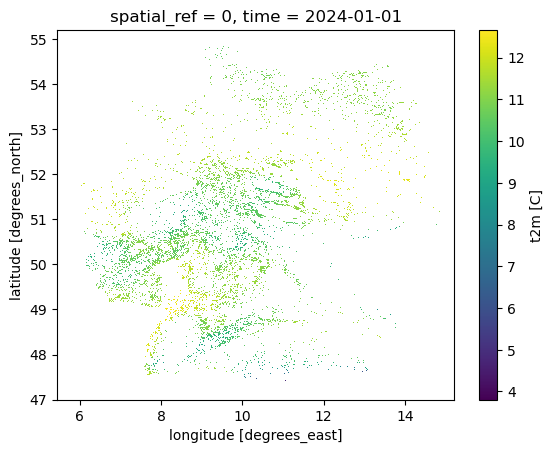

In [8]:
t2m_year_mean.t2m.plot()

In [9]:
# spatially aggregate yearly data
# to get mean values for Germany and federal states

In [10]:
# first, get values for broadleaved forest
# load all yearly t2m values as one dataset
directory = f"./Climate/Temperature/Yearly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
t2m_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [11]:
# calculate mean values per year for Germany
t2m_yearly_spatial_means = t2m_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
t2m_yearly_spatial_means

,t2m,spatial_ref
time,,
1981-01-01,8.074039,0
1982-01-01,8.925705,0
1983-01-01,8.973191,0
1984-01-01,7.956288,0
1985-01-01,7.388951,0
1986-01-01,7.901578,0
1987-01-01,7.412215,0
1988-01-01,9.144113,0
1989-01-01,9.592180,0


In [12]:
# drop unneeded columns
t2m_yearly_spatial_means = t2m_yearly_spatial_means.drop(['spatial_ref'], axis=1)

In [13]:
# rename column with t2m value to show area
t2m_yearly_spatial_means.rename({"t2m":"GER"}, axis=1, inplace=True)

In [14]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    t2m_ex = t2m_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=t2m_ex.odc.geobox.shape,
                                                transform=t2m_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    t2m_state = t2m_yearly["t2m"].where(~state_mask)

    # calculate yearly mean value of state and extract to dataframe
    t2m_state_spatial_means = t2m_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    t2m_state_spatial_means = t2m_state_spatial_means.drop(['spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    t2m_yearly_spatial_means[state] = t2m_state_spatial_means["t2m"]   

In [15]:
t2m_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,8.074039,8.657366,8.841969,8.191801,7.800066,8.728318,7.923311,8.392018,8.214272,8.194127,8.233209,8.134564,8.181703,8.585985,8.169752,8.214765,7.480170
1982-01-01,8.925705,9.575891,9.804956,8.857068,8.507719,9.473725,8.826962,9.135242,8.934986,9.194497,9.251589,8.941898,8.931548,9.368382,9.407863,9.322686,8.571534
1983-01-01,8.973191,9.715444,9.881292,8.965326,8.633567,9.781573,8.822223,9.504413,9.218502,9.231794,9.149771,8.938997,9.273705,9.357005,9.259889,9.293817,8.478686
1984-01-01,7.956288,8.585085,8.734315,7.913321,7.542773,8.827583,7.832155,8.498533,8.270873,8.173627,8.289524,7.994613,8.342400,8.465119,8.062548,8.051485,7.383689
1985-01-01,7.388951,7.984572,8.207362,7.671815,7.093157,8.062218,7.156805,7.718079,7.474745,7.508029,7.470815,7.420019,7.524519,7.905553,7.564270,7.571767,6.807425
1986-01-01,7.901578,8.309723,8.481729,8.098749,7.812444,8.452426,7.791643,8.119570,7.896678,7.915011,7.990522,7.918718,7.926314,8.293286,8.054315,7.936174,7.306211
1987-01-01,7.412215,7.528177,7.715925,7.848904,7.286810,7.882269,7.234260,7.560680,7.188534,7.227569,7.552824,7.627198,7.424816,8.144032,7.232104,7.204278,6.656602
1988-01-01,9.144113,9.601486,9.795579,9.169471,8.844732,9.791542,9.095802,9.431730,9.118731,9.289954,9.330136,9.232915,9.205630,9.599175,9.224757,9.332472,8.641841
1989-01-01,9.592180,10.369888,10.557016,9.533806,9.087118,10.197847,9.461901,9.948298,9.913498,9.874289,9.943646,9.555130,9.808528,9.967210,9.862292,9.947730,9.182274


In [16]:
# save as csv dataset
t2m_yearly_spatial_means.to_csv("./Tables/Spatial_Means/Temperature_Yearly_Spatial_Means_BL.csv")

In [17]:
# now take the same steps for needleleaved forest
# load all yearly values as one dataset
directory = f"./Climate/Temperature/Yearly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
t2m_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [18]:
# calculate mean values per year for Germany
t2m_yearly_spatial_means = t2m_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

In [19]:
# drop unneeded columns
t2m_yearly_spatial_means = t2m_yearly_spatial_means.drop(['spatial_ref'], axis=1)

In [20]:
# rename column with temperature value to show area
t2m_yearly_spatial_means.rename({"t2m":"GER"}, axis=1, inplace=True)

In [21]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    t2m_ex = t2m_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=t2m_ex.odc.geobox.shape,
                                                transform=t2m_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    t2m_state = t2m_yearly["t2m"].where(~state_mask)

    # calculate yearly mean of state and extract to dataframe
    t2m_state_spatial_means = t2m_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    t2m_state_spatial_means = t2m_state_spatial_means.drop(['spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    t2m_yearly_spatial_means[state] = t2m_state_spatial_means["t2m"]   

In [22]:
t2m_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,7.867858,8.799412,8.875156,7.437910,7.253454,8.762872,7.853121,8.464713,8.327816,8.415462,7.468920,8.000456,8.231585,8.374298,7.568255,8.543991,7.005094
1982-01-01,8.763856,9.845192,9.853581,8.184709,7.951279,9.559958,8.792013,9.207457,9.088583,9.360888,8.485687,8.816180,8.988250,9.156511,8.696895,9.604461,8.011196
1983-01-01,8.812578,9.908799,9.924047,8.237093,8.022081,9.808540,8.801188,9.581627,9.336766,9.484843,8.354353,8.814901,9.338627,9.138097,8.656657,9.646460,7.937258
1984-01-01,7.718125,8.721007,8.766440,7.188258,6.916694,8.852533,7.782724,8.569589,8.348699,8.422155,7.484733,7.859008,8.388587,8.259591,7.437547,8.424191,6.830716
1985-01-01,7.227987,8.154172,8.238832,7.055197,6.588294,8.099370,7.134821,7.787867,7.603957,7.758558,6.726578,7.301692,7.580250,7.687464,6.937361,7.930880,6.332420
1986-01-01,7.711694,8.504241,8.523473,7.400161,7.259612,8.488764,7.774383,8.193853,8.001630,8.164451,7.226601,7.773176,7.978141,8.093513,7.472192,8.275336,6.845789
1987-01-01,7.120359,7.707510,7.742943,7.219644,6.745146,7.886420,7.206951,7.631952,7.264638,7.493833,6.808724,7.509464,7.449652,7.943509,6.681690,7.518067,6.171327
1988-01-01,8.848591,9.766610,9.835650,8.355898,8.158541,9.827854,9.035438,9.511804,9.256350,9.467648,8.526820,9.077765,9.273699,9.381571,8.508786,9.594460,8.059490
1989-01-01,9.402875,10.525879,10.594337,8.890948,8.466622,10.216245,9.423480,10.012717,9.997819,10.018043,9.224427,9.436289,9.848877,9.740362,9.215410,10.277657,8.663884


In [23]:
# save as csv dataset
t2m_yearly_spatial_means.to_csv("./Tables/Spatial_Means/Temperature_Yearly_Spatial_Means_NL.csv")